## Imports

In [1]:
import argparse
import os
import time
import random
import gc
import json
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne
import nibabel as nib

from sklearn.model_selection import train_test_split

from IPython.display import Video, HTML

In [2]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from tqdm.notebook import tqdm

manualSeed = 111
SEED = manualSeed

random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
USE_CUDA = torch.cuda.is_available()


def reset_seed(seed=manualSeed):
    torch.manual_seed(seed)
    np.random.seed(seed)


os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

DATA_PATH = '/data/kazachkovda/realWorldTableTennis'

## Read data

Your dataset is organized as follows for each subject (e.g., `sub-01`):

- **`anat` Folder**:
  - `sub-01_T1w.nii`: De-identified T1-weighted anatomical MRI scan in NIfTI format.

- **`eeg` Folder**:
  - `sub-01_task-TableTennis_eeg.set`: EEGLAB dataset file containing EEG data.
  - `sub-01_task-TableTennis_eeg.fdt`: EEGLAB binary data file associated with the `.set` file.
  - `sub-01_task-TableTennis_channels.tsv`: Tab-separated file with channel information.
  - `sub-01_task-TableTennis_coordsystem.json`: JSON file describing the coordinate system.
  - `sub-01_task-TableTennis_electrodes.tsv`: Tab-separated file with electrode positions.
  - `sub-01_task-TableTennis_events.tsv`: Tab-separated file with event information.
  - `sub-01_task-TableTennis_events.json`: JSON file describing the events.

In [34]:
!du -hs /data/kazachkovda/realWorldTableTennis/sub-01

947M	/data/kazachkovda/realWorldTableTennis/sub-01


In [3]:
eeg_dirname = os.path.join(DATA_PATH, 'sub-01', 'eeg/')
anat_dirname = os.path.join(DATA_PATH, 'sub-01', 'anat/')

channels_df = pd.read_csv(eeg_dirname + 'sub-01_task-TableTennis_channels.tsv', sep='\t')
electrodes_df = pd.read_csv(eeg_dirname + 'sub-01_task-TableTennis_electrodes.tsv', sep='\t')
events_df = pd.read_csv(eeg_dirname + 'sub-01_task-TableTennis_events.tsv', sep='\t')

### Data View

In [4]:
print(channels_df.shape)
channels_df.sample(5, random_state=SEED)

(270, 3)


,name,type,units
163,N-CPP3h,MISC,NaN
26,FCC3h,EEG,microV
165,N-P1,MISC,NaN
183,N-C6,MISC,NaN
143,N-FTT9h,MISC,NaN


In [5]:
print(electrodes_df.shape)
electrodes_df.sample(5, random_state=SEED)

(270, 4)


,name,x,y,z
163,N-CPP3h,NaN,NaN,NaN
26,FCC3h,10.37,57.56,113.4
165,N-P1,NaN,NaN,NaN
183,N-C6,NaN,NaN,NaN
143,N-FTT9h,NaN,NaN,NaN


In [6]:
print(events_df.shape)
events_df.sample(5, random_state=SEED)

(2264, 7)


,onset,duration,sample,trial_type,response_time,stim_file,value
1754,2051.416,NaN,512854.0,cooperative,NaN,NaN,Subject_hit
74,303.432,NaN,75858.0,moving_serve,NaN,NaN,Subject_hit
1350,1652.504,NaN,413126.0,competitive,NaN,NaN,Subject_hit
239,568.520,NaN,142130.0,stationary_serve,NaN,NaN,Subject_hit
1262,1545.348,NaN,386337.0,competitive,NaN,NaN,Subject_receive


Number of NaN values

In [7]:
channels_df.isna().mean() * 100

name      0.000000
type      0.000000
units    55.555556
dtype: float64

In [8]:
electrodes_df.isna().mean() * 100

name     0.000000
x       55.555556
y       55.555556
z       55.555556
dtype: float64

In [9]:
events_df.isna().mean() * 100

onset              0.0
duration         100.0
sample             0.0
trial_type         0.0
response_time    100.0
stim_file        100.0
value              0.0
dtype: float64

In [10]:
with open(eeg_dirname + 'sub-01_task-TableTennis_coordsystem.json', 'rb') as fd:
    coord_system = json.load(fd)

with open(eeg_dirname + 'sub-01_task-TableTennis_events.json', 'rb') as fd:
    events = json.load(fd)

In [11]:
coord_system, events

({'EEGCoordinateUnits': 'mm',
  'EEGCoordinateSystem': 'Other',
  'EEGCoordinateSystemDescription': 'EEGLAB'},
 {'onset': {'Description': 'Event onset', 'Units': 'second'},
  'trial_type': {'Description': 'Primary categorization of each trial to identify them as instances of the experimental conditions (equivalent to the EEG.event.condlabel field in the data).',
   'Levels': {'competitive': 'Competitive games with a human player',
    'cooperative': 'Cooperative hitting with a human player',
    'moving_hit': 'Ball machine; machine was oscillating; 1 bounce',
    'moving_serve': 'Ball machine; machine was oscillating; 2 bounces',
    'stationary_hit': 'Ball machine; machine was not oscillating; 1 bounce',
    'stationary_serve': 'Ball machine; machine was not oscillating; 2 bounces'}},
  'value': {'Description': 'Type of event (equivalent to the EEG.event.type field in the data).',
   'Levels': {'M 1': 'Sync event recorded with BrainVision system',
    'Subject_hit': "The participant's

In [12]:
raw_eeg = mne.io.read_raw_eeglab(eeg_dirname + 'sub-01_task-TableTennis_eeg.set', preload=True)

Reading /data/kazachkovda/realWorldTableTennis/sub-01/eeg/sub-01_task-TableTennis_eeg.fdt
Reading 0 ... 785327  =      0.000 ...  3141.308 secs...


/tmp/ipykernel_2052696/554341622.py:1: RuntimeWarning: Unknown types found, setting as type EEG:
acc: ['CGY-x', 'CGY-y', 'CGY-z', 'CWR-x', 'CWR-y', 'CWR-z', 'NGY-x', 'NGY-y', 'NGY-z', 'NWR-x', 'NWR-y', 'NWR-z']
cometas: ['BallMachine_Acc_X(g)', 'BallMachine_Acc_Y(g)', 'BallMachine_Acc_Z(g)', 'Participant_Paddle_Acc_X(g)', 'Participant_Paddle_Acc_Y(g)', 'Participant_Paddle_Acc_Z(g)', 'Researcher_Paddle_Acc_X(g)', 'Researcher_Paddle_Acc_Y(g)', 'Researcher_Paddle_Acc_Z(g)', 'SyncPulse(uV)']
noise: ['N-AF3', 'N-AF4', 'N-AF7', 'N-AF8', 'N-AFF1h', 'N-AFF2h', 'N-AFF5h', 'N-AFF6h', 'N-AFp1', 'N-AFp2', 'N-AFz', 'N-C1', 'N-C2', 'N-C3', 'N-C4', 'N-C5', 'N-C6', 'N-CCP1h', 'N-CCP2h', 'N-CCP3h', 'N-CCP4h', 'N-CCP5h', 'N-CCP6h', 'N-CP1', 'N-CP2', 'N-CP3', 'N-CP4', 'N-CP5', 'N-CP6', 'N-CPP1h', 'N-CPP2h', 'N-CPP3h', 'N-CPP4h', 'N-CPP5h', 'N-CPP6h', 'N-Cz', 'N-F1', 'N-F10', 'N-F2', 'N-F3', 'N-F4', 'N-F5', 'N-F6', 'N-F7', 'N-F8', 'N-F9', 'N-FC1', 'N-FC2', 'N-FC3', 'N-FC4', 'N-FC5', 'N-FC6', 'N-FCC1h', 'N

In [13]:
raw_eeg

<RawEEGLAB | sub-01_task-TableTennis_eeg.fdt, 270 x 785328 (3141.3 s), ~1.58 GB, data loaded>

Чтение nii файла

In [14]:
nifti_img  = nib.load(anat_dirname + 'sub-01_T1w.nii')

nii_data = nifti_img.get_fdata()
nii_aff  = nifti_img.affine
nii_hdr  = nifti_img.header

print(nii_aff ,'\n',nii_hdr)
print(nii_data.shape)

[[   1.     0.     0.  -127.5]
 [   0.     1.     0.  -127.5]
 [   0.     0.     1.  -127.5]
 [   0.     0.     0.     1. ]] 
 <class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : np.bytes_(b'          ')
db_name         : np.bytes_(b'                  ')
extents         : 0
session_error   : 0
regular         : np.bytes_(b' ')
dim_info        : 32
dim             : [  3 256 256 256   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float64
bitpix          : 64
slice_start     : 0
pixdim          : [1. 1. 1. 1. 0. 0. 0. 0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 18
cal_max         : 3613.8875
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : np.bytes_(b'FreeSurfer matlab                                       

Вид сверху-вниз

Slice 1


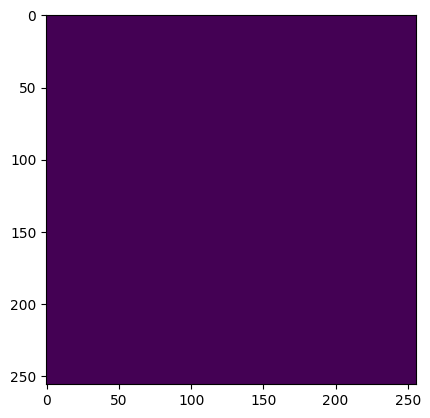

Slice 21


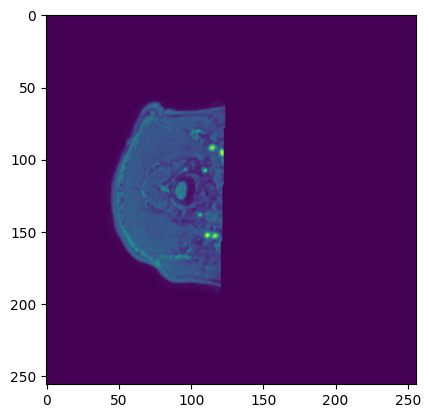

Slice 41


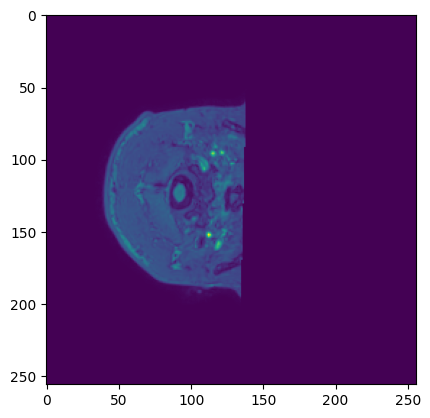

Slice 61


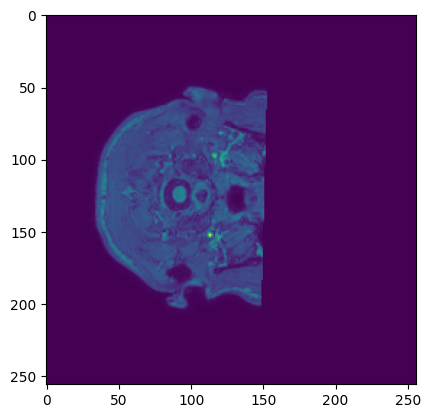

Slice 81


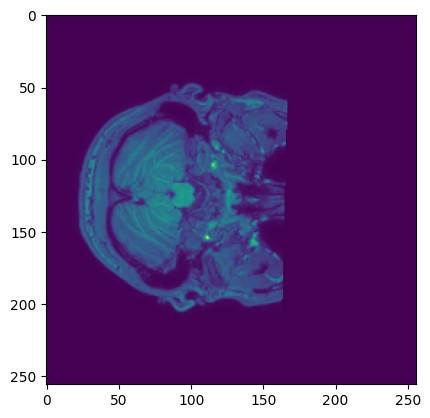

Slice 101


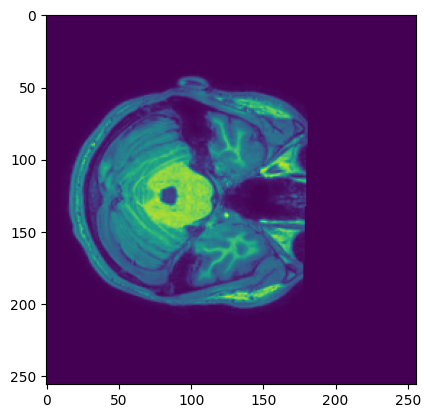

Slice 121


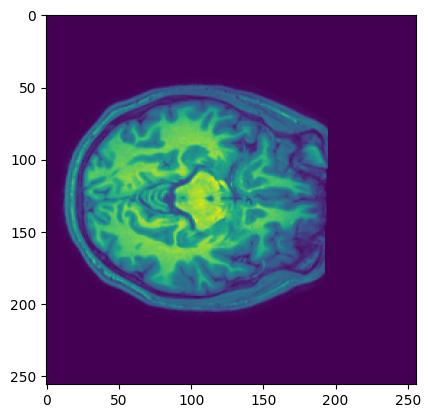

Slice 141


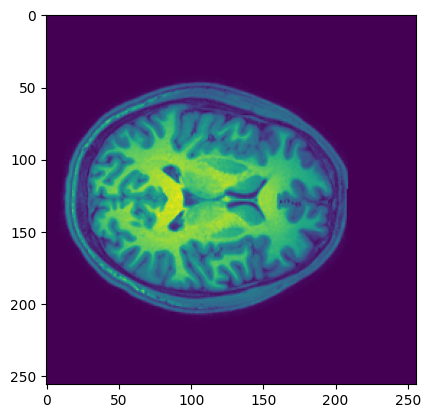

Slice 161


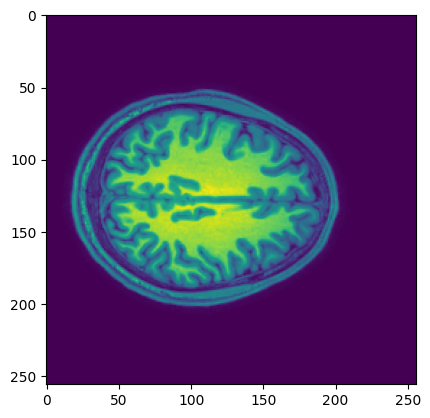

Slice 181


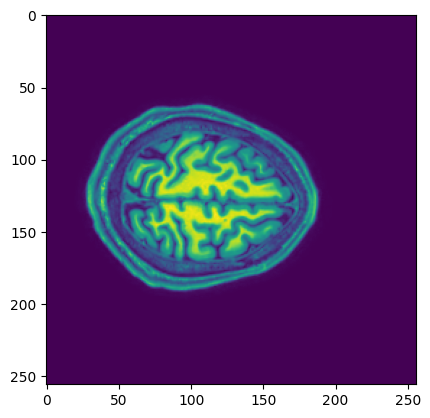

Slice 201


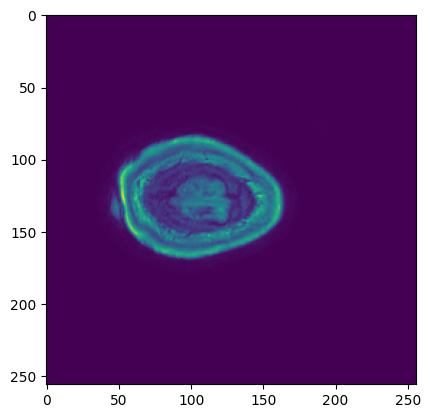

Slice 221


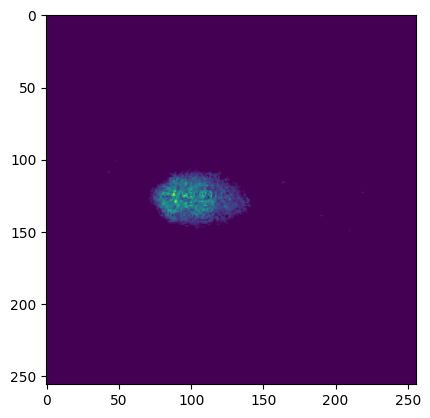

Slice 241


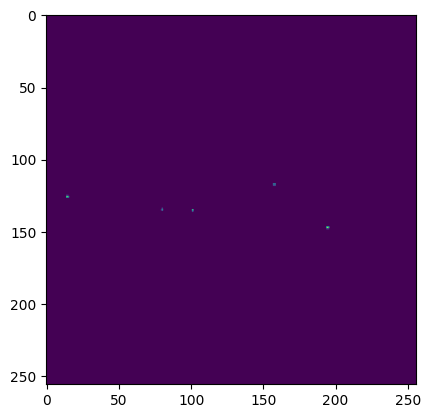

In [58]:
for slice_num in np.arange(0, nii_data.shape[2], 20):
   print(f"Slice {slice_num + 1}")
   plt.imshow(nii_data[:, :, slice_num])
   plt.show()

Вид назад-вперёд

Slice 1


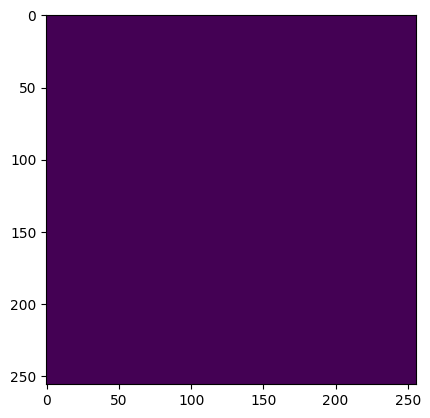

Slice 21


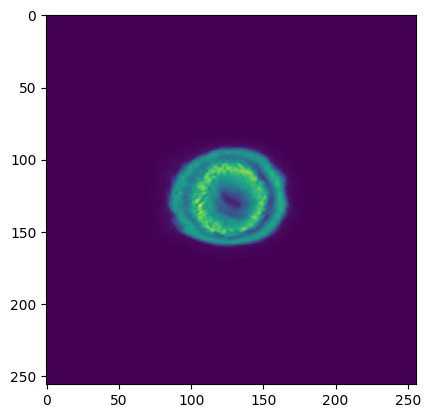

Slice 41


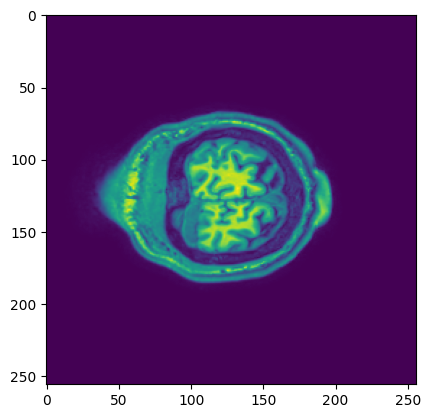

Slice 61


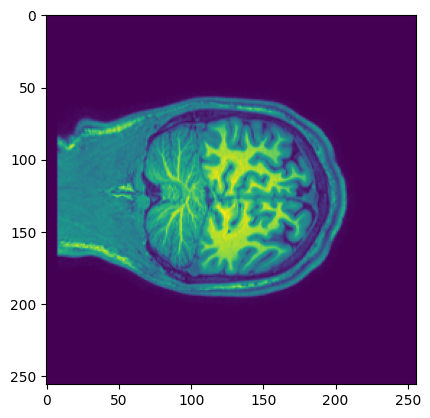

Slice 81


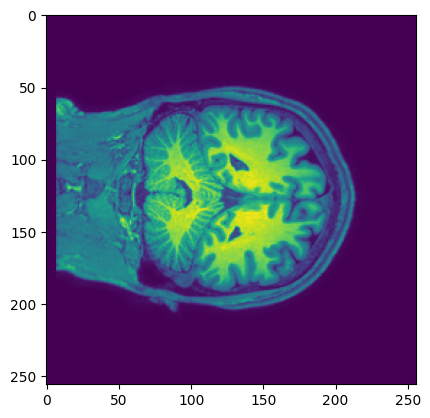

Slice 101


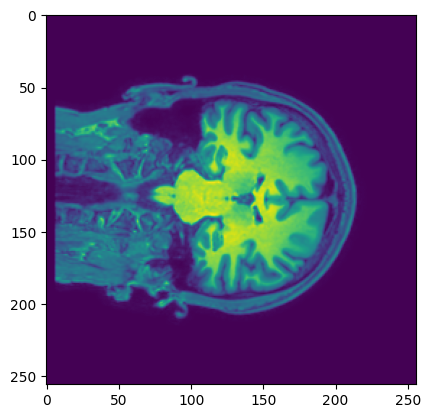

Slice 121


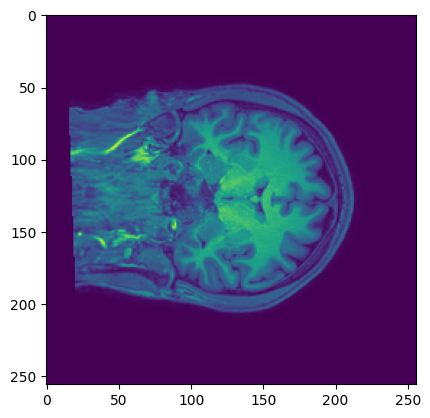

Slice 141


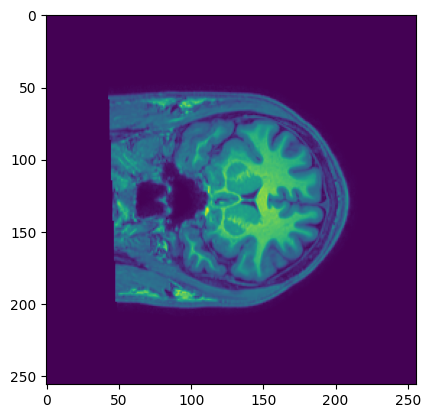

Slice 161


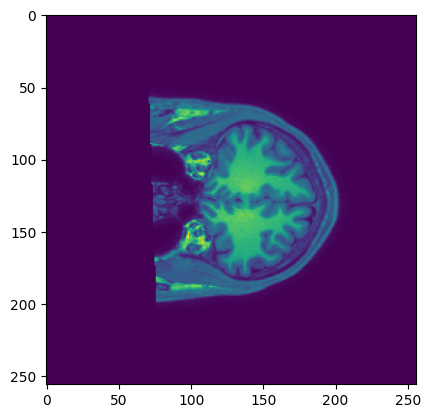

Slice 181


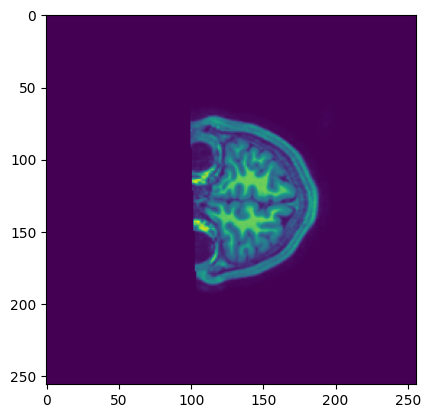

Slice 201


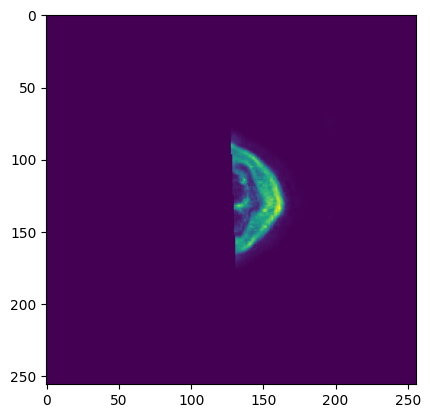

Slice 221


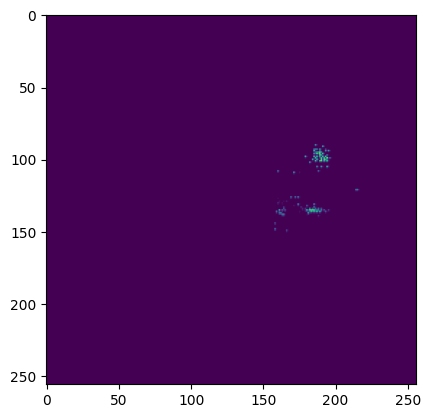

Slice 241


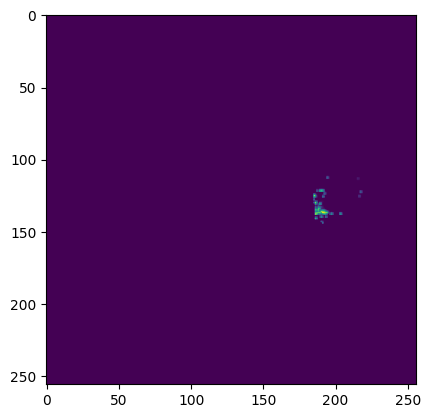

In [59]:
for slice_num in np.arange(0, nii_data.shape[1], 20):
   print(f"Slice {slice_num + 1}")
   plt.imshow(nii_data[:, slice_num, :])
   plt.show()

Вид справа-налево

Slice 1


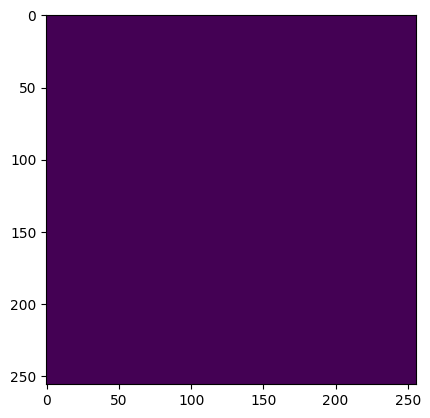

Slice 21


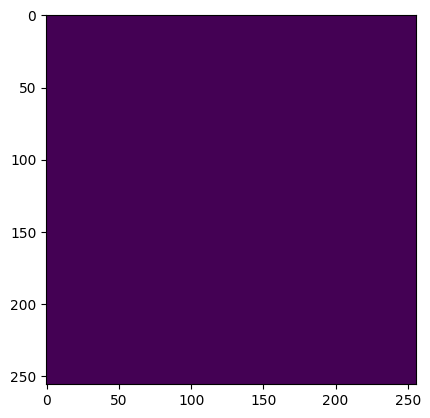

Slice 41


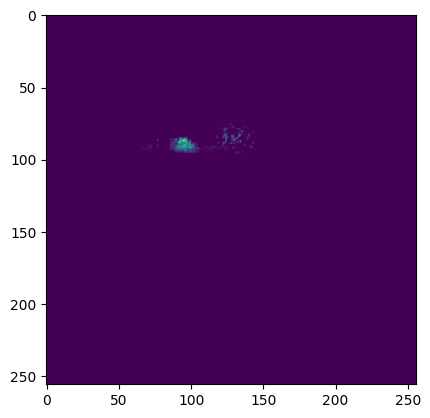

Slice 61


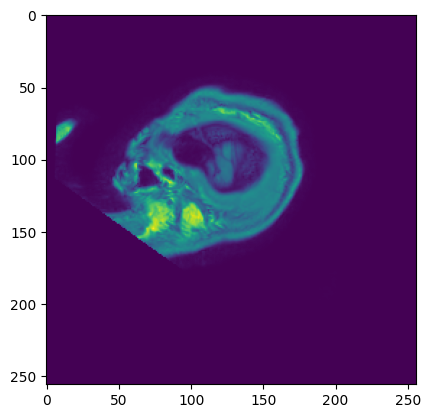

Slice 81


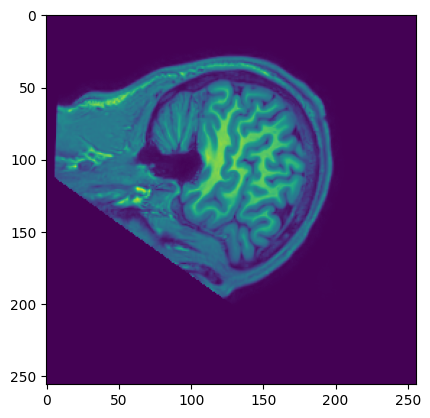

Slice 101


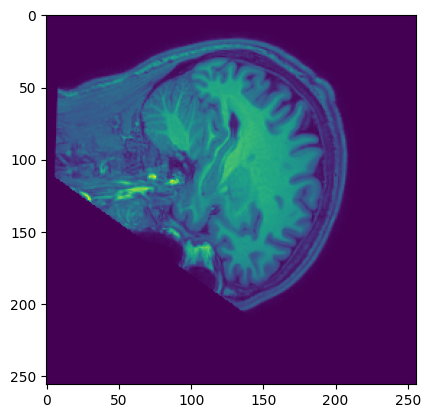

Slice 121


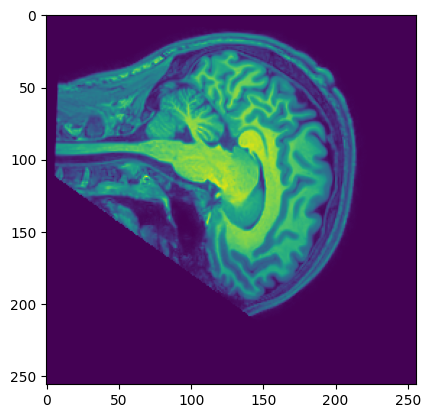

Slice 141


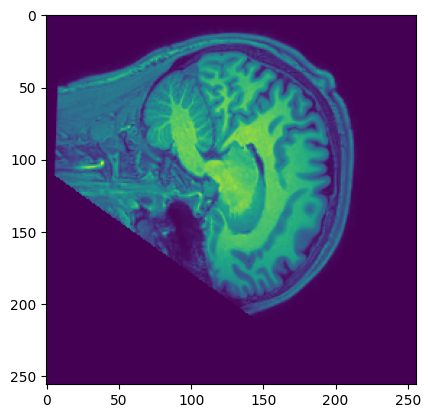

Slice 161


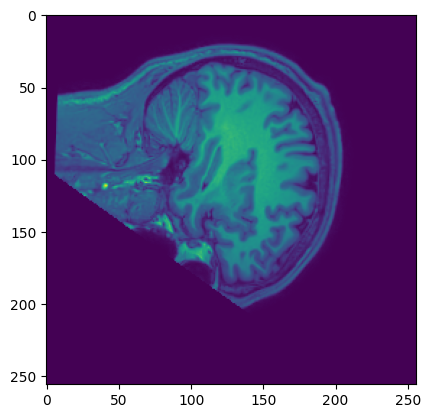

Slice 181


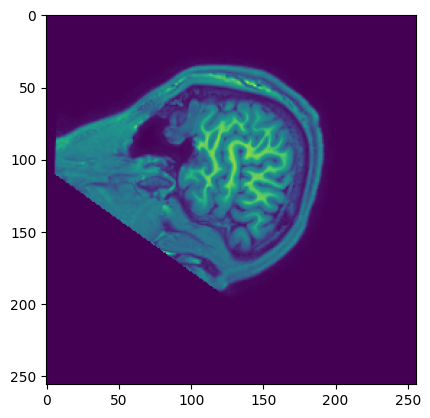

Slice 201


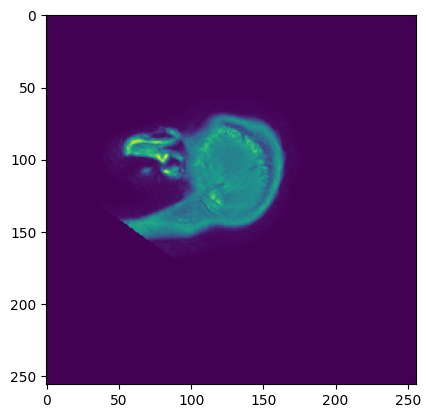

Slice 221


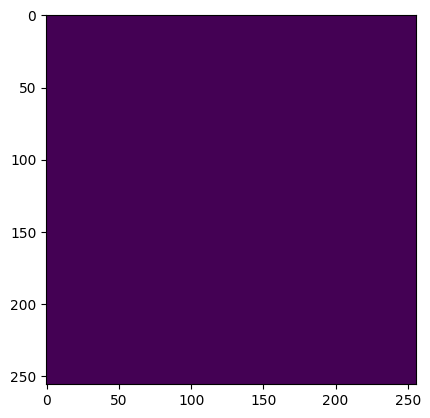

Slice 241


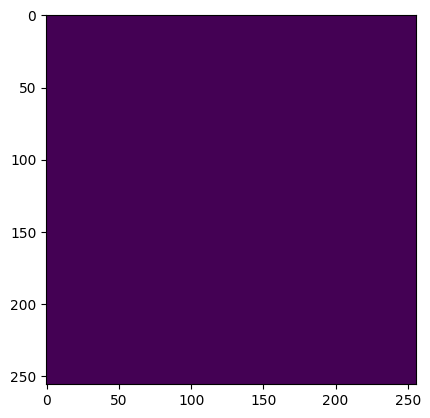

In [60]:
for slice_num in np.arange(0, nii_data.shape[0], 20):
   print(f"Slice {slice_num + 1}")
   plt.imshow(nii_data[slice_num, :, :])
   plt.show()

0 размерность -- вид сбоку

1 размерность -- вид сзади

2 размерность -- вид сверху

### Устанавливаем типы каналов

In [15]:
channels_df

,name,type,units
0,Fp1,EEG,microV
1,AFp1,EEG,microV
2,AFz,EEG,microV
3,AF3,EEG,microV
4,AF7,EEG,microV
...,...,...,...
265,BallMachine_Acc_Y(g),MISC,NaN
266,Researcher_Paddle_Acc_Y(g),MISC,NaN
267,Participant_Paddle_Acc_Z(g),MISC,NaN
268,BallMachine_Acc_Z(g),MISC,NaN


In [16]:
channels_df.type.value_counts()

type
MISC    142
EEG     120
EMG       8
Name: count, dtype: int64

In [18]:
eeg_channels = channels_df[channels_df['type'] == 'EEG']['name'].tolist()
emg_channels = channels_df[channels_df['type'] == 'EMG']['name'].tolist()
misc_channels = channels_df[channels_df['type'] == 'MISC']['name'].tolist()

# Set channel types
channel_types = {}
for ch in raw_eeg.ch_names:
    if ch in eeg_channels:
        channel_types[ch] = 'eeg'
    elif ch in emg_channels:
        channel_types[ch] = 'emg'
    else:
        channel_types[ch] = 'misc'  # Includes IMU and other sensors

raw_eeg.set_channel_types(channel_types)

/tmp/ipykernel_2052696/49138378.py:15: RuntimeWarning: The unit for channel(s) BallMachine_Acc_X(g), BallMachine_Acc_Y(g), BallMachine_Acc_Z(g), CGY-x, CGY-y, CGY-z, CWR-x, CWR-y, CWR-z, N-AF3, N-AF4, N-AF7, N-AF8, N-AFF1h, N-AFF2h, N-AFF5h, N-AFF6h, N-AFp1, N-AFp2, N-AFz, N-C1, N-C2, N-C3, N-C4, N-C5, N-C6, N-CCP1h, N-CCP2h, N-CCP3h, N-CCP4h, N-CCP5h, N-CCP6h, N-CP1, N-CP2, N-CP3, N-CP4, N-CP5, N-CP6, N-CPP1h, N-CPP2h, N-CPP3h, N-CPP4h, N-CPP5h, N-CPP6h, N-Cz, N-F1, N-F10, N-F2, N-F3, N-F4, N-F5, N-F6, N-F7, N-F8, N-F9, N-FC1, N-FC2, N-FC3, N-FC4, N-FC5, N-FC6, N-FCC1h, N-FCC2h, N-FCC3h, N-FCC4h, N-FCC5h, N-FCC6h, N-FCz, N-FFC1h, N-FFC2h, N-FFC3h, N-FFC4h, N-FFC5h, N-FFC6h, N-FFT10h, N-FFT7h, N-FFT8h, N-FFT9h, N-FP2, N-FT10, N-FT7, N-FT8, N-FT9, N-FTT10h, N-FTT7h, N-FTT8h, N-FTT9h, N-Fp1, N-Fz, N-Iz, N-O1, N-O2, N-O9, N-OI1h, N-OI2h, N-Oz, N-P1, N-P2, N-P3, N-P4, N-P5, N-P6, N-P7, N-P8, N-PO3, N-PO4, N-PO7, N-PO8, N-POO1, N-POO10h, N-POO2, N-POz, N-PPO10h, N-PPO1h, N-PPO2h, N-PPO5h, N

<RawEEGLAB | sub-01_task-TableTennis_eeg.fdt, 270 x 785328 (3141.3 s), ~1.58 GB, data loaded>

Watch channels names

In [31]:
eeg_channels, misc_channels

(['Fp1',
  'AFp1',
  'AFz',
  'AF3',
  'AF7',
  'AFF5h',
  'AFF1h',
  'F1',
  'F3',
  'F5',
  'F7',
  'F9',
  'FFT9h',
  'FFT7h',
  'FFC5h',
  'FFC3h',
  'FFC1h',
  'FCz',
  'FC1',
  'FC3',
  'FC5',
  'FT7',
  'FT9',
  'FTT9h',
  'FTT7h',
  'FCC5h',
  'FCC3h',
  'FCC1h',
  'C1',
  'C3',
  'C5',
  'T7',
  'TTP7h',
  'CCP5h',
  'CCP3h',
  'CCP1h',
  'CP1',
  'CP3',
  'CP5',
  'TP7',
  'TPP9h',
  'TPP7h',
  'CPP5h',
  'CPP3h',
  'CPP1h',
  'P1',
  'P3',
  'P5',
  'P7',
  'PPO5h',
  'PPO1h',
  'POz',
  'PO3',
  'PO7',
  'PPO9h',
  'O1',
  'POO1',
  'O9',
  'OI1h',
  'Iz',
  'Cz',
  'C2',
  'C4',
  'C6',
  'T8',
  'FTT10h',
  'FTT8h',
  'FCC6h',
  'FCC4h',
  'FCC2h',
  'FC2',
  'FC4',
  'FC6',
  'FT8',
  'FT10',
  'FFT10h',
  'FFT8h',
  'FFC6h',
  'FFC4h',
  'FFC2h',
  'Fz',
  'F2',
  'F4',
  'F6',
  'F8',
  'F10',
  'AFF6h',
  'AFF2h',
  'AF4',
  'AF8',
  'FP2',
  'AFp2',
  'Oz',
  'OI2h',
  'POO10h',
  'O2',
  'POO2',
  'PO4',
  'PO8',
  'PPO10h',
  'PPO6h',
  'PPO2h',
  'Pz',
  'P2',
  '

Заметим, что первые 120 misc каналов дублируют все 120 ЭЭГ каналов, но с префиксом `N-`

Детальнее изучим остальные каналы:

- 'CGY-x', 'CGY-y', 'CGY-z' --  
- 'CWR-x', 'CWR-y', 'CWR-z' -- 
- 'NGY-x', 'NGY-y', 'NGY-z' -- 
- 'NWR-x', 'NWR-y', 'NWR-z' --

  'SyncPulse(uV)',
  'Participant_Paddle_Acc_X(g)',
  'BallMachine_Acc_X(g)',
  'Researcher_Paddle_Acc_X(g)',
  'Participant_Paddle_Acc_Y(g)',
  'BallMachine_Acc_Y(g)',
  'Researcher_Paddle_Acc_Y(g)',
  'Participant_Paddle_Acc_Z(g)',
  'BallMachine_Acc_Z(g)',
  'Researcher_Paddle_Acc_Z(g)'

### Решаем, что делать с пропусками в датафрейме с позициями электродов

In [19]:
electrodes_df

,name,x,y,z
0,Fp1,101.22,35.54,54.21
1,AFp1,101.78,21.71,71.29
2,AFz,98.68,7.06,85.33
3,AF3,87.87,42.14,74.05
4,AF7,81.06,60.27,46.16
...,...,...,...,...
265,BallMachine_Acc_Y(g),NaN,NaN,NaN
266,Researcher_Paddle_Acc_Y(g),NaN,NaN,NaN
267,Participant_Paddle_Acc_Z(g),NaN,NaN,NaN
268,BallMachine_Acc_Z(g),NaN,NaN,NaN


In [20]:
electrodes_df.name[electrodes_df.x.notna()]

0        Fp1
1       AFp1
2        AFz
3        AF3
4        AF7
       ...  
115      TP8
116    TTP8h
117    CCP6h
118    CCP4h
119    CCP2h
Name: name, Length: 120, dtype: object

Нетрудно заметить, что позиции электродов не указаны у не-ЭЭГ датчиков, что очевидно.

Поэтому можем их спокойно удалить.

In [21]:
electrodes_df.dropna(inplace=True)

### Извлекаем события и создаём аннотации

In [22]:
annotations = raw_eeg.annotations
events, event_id = mne.events_from_annotations(raw_eeg)

Used Annotations descriptions: [np.str_('M  1'), np.str_('Subject_hit'), np.str_('Subject_receive'), np.str_('boundary')]


In [23]:
annotations

<Annotations | 2263 segments: M 1 (516), Subject_hit (1104), ...>

In [25]:
events.shape, events

((2263, 3),
 array([[   304,      0,      1],
        [  1554,      0,      1],
        [  2803,      0,      1],
        ...,
        [695975,      0,      1],
        [695990,      0,      2],
        [696619,      0,      2]]))

In [26]:
np.unique(events[:, 1])

array([0])

In [27]:
np.unique(events[:, 2])

array([1, 2, 3, 4])

In [28]:
success_events = [event_id['Subject_hit']]
labels = np.array([1 if event[2] in success_events else 0 for event in events])

Извлекаем сессии игры с исследователем